In [1]:
%matplotlib inline
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
import seaborn as sns
import functools

np.random.seed(0)
sns.set_context('paper')
plt.rcParams["figure.figsize"] = (8, 8)

EPS = 1.01

@functools.total_ordering
class Classifier:
    def __eq__(self, other):
        return self.loss == other.loss

    def __lt__(self, other):
        return self.loss < other.loss

    def __str__(self):
        return 'loss: {}\nw: {}\nb: {}'.format(self.loss,
                                               np.squeeze(self.w), self.b)

    def classify(self, x):
        score = x.dot(self.w) + self.b
        y = np.sign(score)
        y[np.abs(score) < self.d] = 0

        return np.asarray(y)


class RejectSVM(Classifier):
    def __init__(self, d):
        assert (0 <= d <= 0.5)
        self.d = d

    def fit(self, x, y):
        assert (np.all(np.logical_or(y == 1, y == -1)))
        assert (x.shape[0] == y.shape[0])

        num_samples, num_features = x.shape
        d = self.d

        w = cvx.Variable(num_features)
        b = cvx.Variable()
        xi = cvx.Variable(num_samples)
        gamma = cvx.Variable(num_samples)

        loss = cvx.sum_squares(w) + cvx.sum_entries(
            xi + (1 - 2 * d) / d * gamma) / num_samples
        constraints = [
            xi >= 0,
            gamma >= 0,
            xi >= 1 - cvx.mul_elemwise(y, x * w + b),
            gamma >= -cvx.mul_elemwise(y, x * w + b)
        ]
        problem = cvx.Problem(cvx.Minimize(loss), constraints)
        result = problem.solve()
        
        if problem.status != cvx.OPTIMAL:
            raise RuntimeError('RejectSVM not solved. Status: {}'.format(problem.status))

        self.w = np.asarray(w.value)
        self.b = b.value
        self.xi = np.asarray(xi.value)
        self.gamma = np.asarray(gamma.value)
        self.loss = loss.value
        
        print(self)

        return result


class MinRel(Classifier):
    def __init__(self, d, w, xi, gamma, j):
        self.d = d
        self.w = w
        self.xi = xi
        self.gamma = gamma
        self.j = j

    def fit(self, x, y):
        assert (np.all(np.logical_or(y == 1, y == -1)))
        assert (x.shape[0] == y.shape[0])

        num_samples, num_features = x.shape
        d = self.d
        j = self.j

        w = cvx.Variable(num_features)
        b = cvx.Variable()
        xi = cvx.Variable(num_samples)
        gamma = cvx.Variable(num_samples)

        loss = cvx.abs(w[j])
        constraints = [
            xi >= 0,
            gamma >= 0,
            xi >= 1 - cvx.mul_elemwise(y, x * w + b),
            gamma >= -cvx.mul_elemwise(y, x * w + b),
            cvx.norm(w, p=1) <= np.linalg.norm(self.w, ord=1),
            cvx.sum_entries(xi + (1 - 2 * d) / d * gamma) <=
            np.sum(self.xi + (1 - 2 * d) / d * self.gamma) * EPS
        ]
        problem = cvx.Problem(cvx.Minimize(loss), constraints)
        result = problem.solve()
        
        if problem.status != cvx.OPTIMAL:
            raise RuntimeError('Min Rel not solved. Status: {}'.format(problem.status))

        self.w = np.asarray(w.value)
        self.b = b.value
        self.xi = np.asarray(xi.value)
        self.gamma = np.asarray(gamma.value)
        self.loss = loss.value
        
        print(self)

        return result


class MaxRelPos(Classifier):
    def __init__(self, d, w, xi, gamma, j):
        self.d = d
        self.w = w
        self.xi = xi
        self.gamma = gamma
        self.j = j

    def fit(self, x, y):
        assert (np.all(np.logical_or(y == 1, y == -1)))
        assert (x.shape[0] == y.shape[0])

        num_samples, num_features = x.shape
        d = self.d
        j = self.j

        w = cvx.Variable(num_features)
        b = cvx.Variable()
        xi = cvx.Variable(num_samples)
        gamma = cvx.Variable(num_samples)

        loss = w[j]
        constraints = [
            xi >= 0,
            gamma >= 0,
            xi >= 1 - cvx.mul_elemwise(y, x * w + b),
            gamma >= -cvx.mul_elemwise(y, x * w + b),
            cvx.norm(w, p=1) <= np.linalg.norm(self.w, ord=1),
            cvx.sum_entries(xi + (1 - 2 * d) / d * gamma) <=
            np.sum(self.xi + (1 - 2 * d) / d * self.gamma) * EPS
        ]
        problem = cvx.Problem(cvx.Maximize(loss), constraints)
        result = problem.solve()
        
        if problem.status != cvx.OPTIMAL:
            raise RuntimeError('Max Rel Pos not solved. Status: {}'.format(problem.status))

        self.w = np.asarray(w.value)
        self.b = b.value
        self.xi = np.asarray(xi.value)
        self.gamma = np.asarray(gamma.value)
        self.loss = loss.value
        
        print(self)

        return result


class MaxRelNeg(Classifier):
    def __init__(self, d, w, xi, gamma, j):
        self.d = d
        self.w = w
        self.xi = xi
        self.gamma = gamma
        self.j = j

    def fit(self, x, y):
        assert (np.all(np.logical_or(y == 1, y == -1)))
        assert (x.shape[0] == y.shape[0])

        num_samples, num_features = x.shape
        d = self.d
        j = self.j

        w = cvx.Variable(num_features)
        b = cvx.Variable()
        xi = cvx.Variable(num_samples)
        gamma = cvx.Variable(num_samples)

        loss = -w[j]
        constraints = [
            xi >= 0,
            gamma >= 0,
            xi >= 1 - cvx.mul_elemwise(y, x * w + b),
            gamma >= -cvx.mul_elemwise(y, x * w + b),
            cvx.norm(w, p=1) <= np.linalg.norm(self.w, ord=1),
            cvx.sum_entries(xi + (1 - 2 * d) / d * gamma) <=
            np.sum(self.xi + (1 - 2 * d) / d * self.gamma) * EPS
        ]
        problem = cvx.Problem(cvx.Maximize(loss), constraints)
        result = problem.solve()
        
        if problem.status != cvx.OPTIMAL:
            raise RuntimeError('Max Rel Neg not solved. Status: {}'.format(problem.status))

        self.w = np.asarray(w.value)
        self.b = b.value
        self.xi = np.asarray(xi.value)
        self.gamma = np.asarray(gamma.value)
        self.loss = loss.value
        
        print(self)

        return result


def calculate_hyperplane(w, b, lim):
    w = np.copy(w)
    x_hyperplane = np.array(lim)
    if abs(w[1]) < 1e-4:
        w[1] = 1e-4
    y_hyperplane = (-b - w[0] * x_hyperplane) / w[1]
    return x_hyperplane, y_hyperplane


def classify_and_plot(classifier, title, x, y, ax):
    classifier.fit(x, y)
    y_est = classifier.classify(x)
    ax.set_title(title)
    ax.scatter(x[:, 0], x[:, 1], c=y_est)
    ax.set_aspect('equal')
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    x_hyp, y_hyp = calculate_hyperplane(classifier.w, classifier.b, x_lim)
    ax.plot(x_hyp, y_hyp)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
def visualize(x, y, d=0.4, j=0):
    fig = plt.figure()
    
    svm = RejectSVM(d)
    ax = fig.add_subplot(221)
    classify_and_plot(svm, 'Reject SVM', x, y, ax)

    min_rel = MinRel(d, svm.w, svm.xi, svm.gamma, j)
    ax = fig.add_subplot(222)
    classify_and_plot(min_rel, 'Min Rel', x, y, ax)
    
    max_rel_pos = MaxRelPos(d, svm.w, svm.xi, svm.gamma, j)
    ax = fig.add_subplot(223)
    classify_and_plot(max_rel_pos, 'Max Rel Pos', x, y, ax)
    
    max_rel_neg = MaxRelNeg(d, svm.w, svm.xi, svm.gamma, j)
    ax = fig.add_subplot(224)
    classify_and_plot(max_rel_neg, 'Max Rel Neg', x, y, ax)

    fig.tight_layout()
    
    print('Winner:', 'Max Rel Pos'
          if max_rel_pos > max_rel_neg else 'Max Rel Neg')

In [2]:
# Gaussian distribution.
def test():
    num_samples = 1000
    num_features = 2
    w_true = np.random.randn(num_features, 1)
    b_true = 0
    x = np.random.normal(0, 5, size=(num_samples, num_features))
    y = np.sign(x.dot(w_true) + b_true + np.random.normal(0, 1, size=(num_samples, 1)))

    visualize(x, y)

loss: 0.339156270113103
w: [ 0.32367322  0.08467734]
b: 0.005197120314544336
loss: 0.3192941333767101
w: [ 0.31929413  0.08905643]
b: 0.007988970024851863
loss: 0.3758527827126915
w: [ 0.37585278  0.03249778]
b: 0.040526415203167375
loss: -0.3192941333810174
w: [ 0.31929413  0.08905643]
b: 0.007988969855211766
Winner: Max Rel Pos


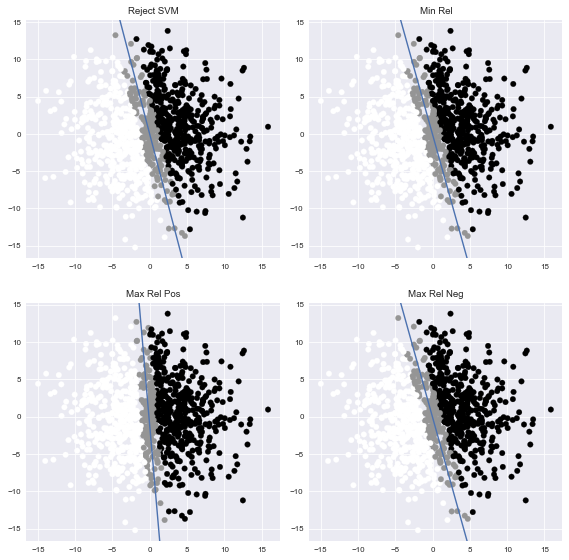

In [3]:
test()

In [4]:
# Perfectly correlated features.
def test():
    num_samples = 1000
    num_features = 2
    w_true = np.random.randn(num_features, 1)
    b_true = 0
    x = np.random.normal(0, 5, size=(num_samples, 1))
    x = np.concatenate((x, x), axis=1)
    y = np.sign(x.dot(w_true) + b_true + np.random.normal(0, 1, size=(num_samples, 1)))

    visualize(x, y)

loss: 0.8033364582883491
w: [ 0.07856149  0.07856149]
b: 0.03922062298264901
loss: 7.330692386461197e-15
w: [ -7.33069239e-15   1.55959175e-01]
b: 0.03651319698930378
loss: 0.15712298618961115
w: [  1.57122986e-01  -2.35638979e-13]
b: 0.03733232764681212
loss: 0.011969409896078125
w: [-0.01196941  0.14515358]
b: 0.014197517785848138
Winner: Max Rel Pos


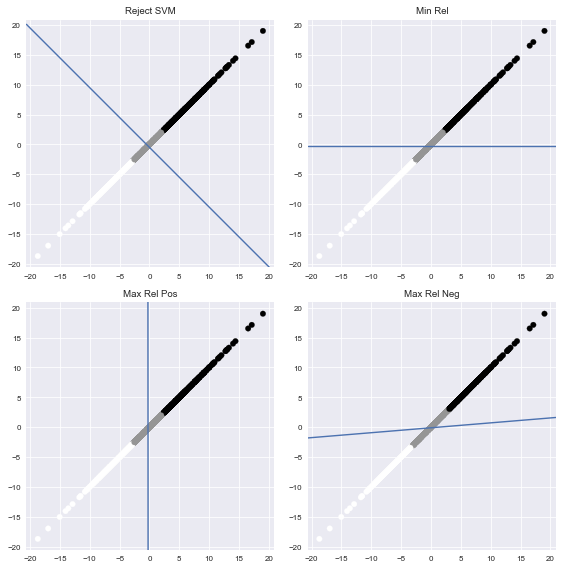

In [5]:
test()

In [6]:
# More noise towards origin.
import random
def test():
    num_samples = 2000
    num_features = 2
    x = np.zeros((num_samples, num_features))
    y = np.ones((num_samples, 1))
    for i in range(num_samples):
        # Put either on the left or the right side and label accordingly.
        if random.uniform(0, 1) < 0.5:
            y[i] = -1
            x[i, 0] = random.uniform(-1, 0)
        else:
            y[i] = 1
            x[i, 0] = random.uniform(0, 1)
        x[i, 1] = x[i, 0]

        # Add a little bit of noise.
        x[i, 0] += random.gauss(0, 0.02)
        x[i, 1] += random.gauss(0, 0.02)

        # Add a lot of noise to the vertical variable, but only sometimes.
        if random.uniform(0, 1) < 0.5 * (1 - abs(x[i, 0]))**3:
            x[i, 0] += random.gauss(0, 0.2)

        # Add a lot of noise to the horizontal variable, but only sometimes.
        if random.uniform(0, 1) < 0.2 * (1 - abs(x[i, 1]))**3:
            x[i, 1] += random.gauss(0, 0.2)
    x *= 8

    visualize(x, y)

loss: 0.24771563252780238
w: [ 0.19136595  0.20472773]
b: -0.05196368451263942
loss: 0.00028338597041691207
w: [  2.83385970e-04   3.95810294e-01]
b: -0.059282358733398995
loss: 0.2395355235144195
w: [ 0.23953552  0.15655816]
b: -0.05638641475818237
loss: -0.00028338608215662715
w: [  2.83386082e-04   3.95810294e-01]
b: -0.059230967421348986
Winner: Max Rel Pos


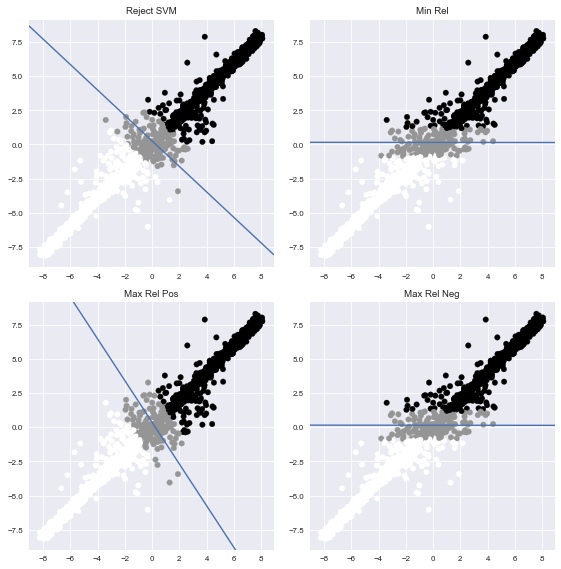

In [7]:
test()

In [8]:
# Sparser towards the origin.
def test():
    num_samples = 2000
    num_features = 2
    x = np.random.normal(0, 5, size=(num_samples, num_features))
    x[:, 1] *= 0.1
    left_idx = x[:, 0] < 0
    right_idx = x[:, 0] >= 0
    x[left_idx, 0] += 12
    x[right_idx, 0] -= 12
    y = np.ones((num_samples, 1))
    y[left_idx] = -1
    theta = np.pi * 0.25
    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),
    np.cos(theta)]])
    x = np.asarray((rot * np.asmatrix(x.T)).T)
    
    visualize(x, y)

loss: 0.11576632958854782
w: [-0.14150962 -0.14562443]
b: 0.017876782112673933
loss: 4.6439483818777843e-14
w: [ -4.64394838e-14  -2.87089236e-01]
b: 0.02215567267535065
loss: 0.00012859701827578257
w: [  1.28597018e-04  -2.87005449e-01]
b: 0.021623399846360754
loss: 0.2001672999886156
w: [-0.2001673  -0.08696675]
b: 0.030197478781965346
Winner: Max Rel Neg


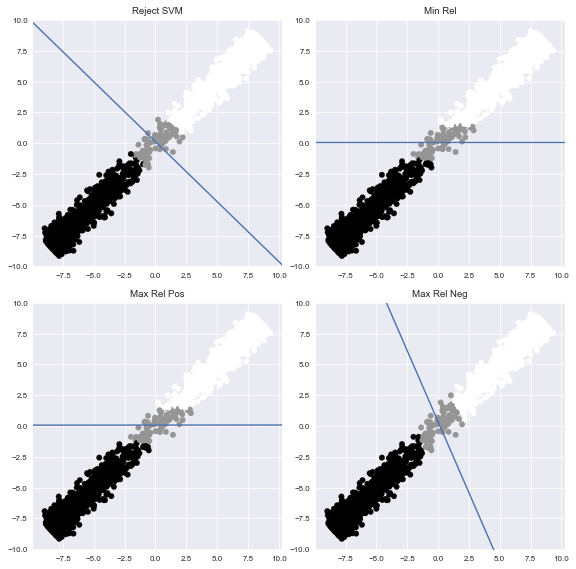

In [9]:
test()

In [10]:
# Noisy towards origin.
def test():
    num_features = 2
    num_samples = 1000
    x = np.random.uniform(low=-1.0, high=1.0, size=(num_samples, num_features))
    x[:,1] *= np.power(1 - np.abs(x[:,0]), 2)
    y = np.ones((num_samples, 1))
    y[x[:, 0] + np.random.normal(0, 0.2, size = num_samples) < 0] = -1
    x[:,0] *= 2
    theta = np.pi * 0.3
    rot = np.matrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    x = np.asarray(np.dot(x, rot.T))
    x *= 10
    visualize(x, y)

loss: 0.2461089773256993
w: [ 0.09989939 -0.15737787]
b: -0.09766892327089259
loss: 0.06274168887911183
w: [ 0.06274169 -0.19453556]
b: -0.06741570732525946
loss: 0.11295245851086388
w: [ 0.11295246 -0.14432479]
b: -0.07984941439124982
loss: -0.06274168878591513
w: [ 0.06274169 -0.19453556]
b: -0.0690711055538097
Winner: Max Rel Pos


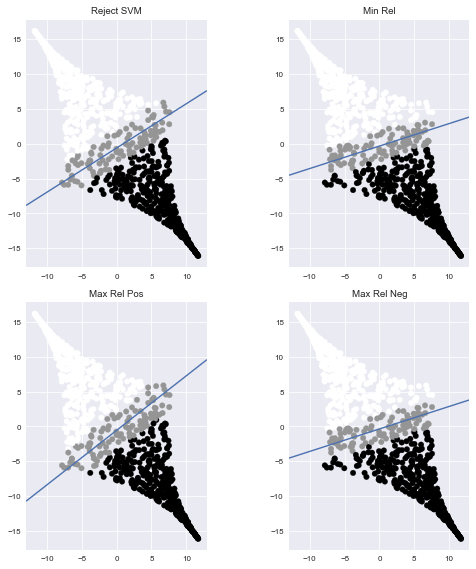

In [11]:
test()